In [52]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

In [53]:
# load in the census blocks from the ArcGIS source
blocks = gpd.read_file('./data/arcgisCensusBlocks.geojson')
print(blocks.crs)

epsg:4326


In [54]:
# load in the city boundary from the Chicago Data Portal
bound = gpd.read_file('./data/Boundaries - City.geojson')
print(bound.crs)

epsg:4326


In [55]:
blocks = blocks.to_crs('epsg:26916')
bound = bound.to_crs('epsg:26916')
assert blocks.crs.equals(bound.crs)

In [56]:
blocks.head()

,OBJECTID,AREALAND,AREAWATER,BASENAME,BLKGRP,BLOCK,CENTLAT,CENTLON,COUNTY,FUNCSTAT,...,ObjID,STATE,SUFFIX,TRACT,UR,HU100,POP100,SHAPE_Length,SHAPE_Area,geometry
0,382512,10765.0,0.0,1004,1,1004,+42.1253541,-088.0432581,031,S,...,210701006232286,17,None,803604,None,0.0,0.0,0.004724,1.172067e-06,"MULTIPOLYGON (((413726.964 4664320.583, 413738..."
1,382513,6240.0,0.0,1000,1,1000,+42.1249884,-088.0400862,031,S,...,210701006232287,17,None,803604,None,0.0,0.0,0.004156,6.793596e-07,"MULTIPOLYGON (((413949.605 4664159.287, 413966..."
2,382514,13289.0,0.0,4007,4,4007,+42.1283062,-088.0219304,031,S,...,210701006232288,17,None,803605,None,0.0,0.0,0.009855,1.447040e-06,"MULTIPOLYGON (((415358.019 4664530.155, 415358..."
3,382515,43305.0,0.0,1006,1,1006,+42.1346401,-088.0252379,031,S,...,210701006232289,17,None,803605,None,17.0,56.0,0.008623,4.715658e-06,"MULTIPOLYGON (((415169.106 4665140.195, 415169..."
4,382516,311638.0,0.0,1009,1,1009,+42.0332301,-087.7910624,031,S,...,210701006232290,17,None,808301,None,0.0,0.0,0.043847,3.388186e-05,"MULTIPOLYGON (((434234.864 4653773.370, 434236..."


In [57]:
bound.head()

,name,objectid,shape_area,shape_len,geometry
0,CHICAGO,1,6450276623.31,845282.931362,"MULTIPOLYGON (((422554.322 4650297.866, 422548..."


In [58]:
assert not blocks['GEOID'].duplicated().any()
blocks.set_index('GEOID',inplace=True)

C:\Users\aance\anaconda3\envs\geoEnv\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
C:\Users\aance\anaconda3\envs\geoEnv\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<AxesSubplot:>

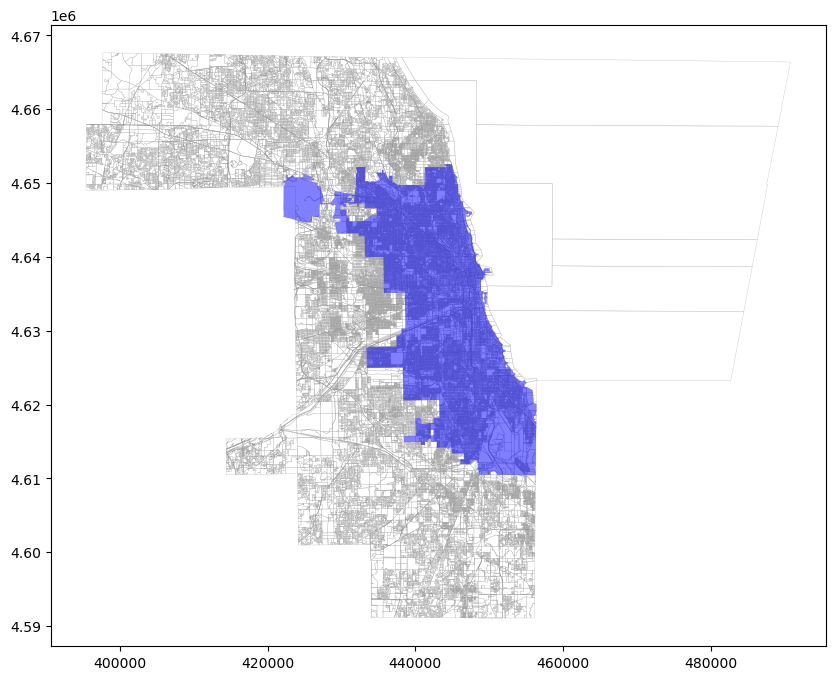

In [46]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
blocks.plot(ax=ax,color='white',edgecolor='grey',linewidth=0.25,alpha=0.5)
bound.plot(ax=ax,color='blue',alpha=0.5)

In [59]:
# find blocks that are in or intersect w/ the city
intersectCity = blocks.intersects(bound.loc[0,'geometry'])
inCity = blocks.within(bound.loc[0,'geometry'])
onBound = intersectCity & ~inCity
print(intersectCity.sum(),inCity.sum(),onBound.sum(),len(blocks))

39452 37969 1483 83018


In [60]:
assert (inCity & intersectCity).equals(inCity) # inCity should be a subset of intersectCity

In [61]:
# select only blocks intersecting w/ the city
blocks['intersectCity'] = intersectCity
blocks['inCity'] = inCity
blocks['onBound'] = onBound
cityBlocks = blocks.loc[blocks['intersectCity']].copy()
# for blocks on the boundary, intersect them w/ the city
cityBlocks['oldGeometry'] = cityBlocks['geometry'] # store old geometry for spot checking the intersection op
cityBlocks.loc[cityBlocks['onBound'],'geometry'] = cityBlocks.loc[cityBlocks['onBound']].intersection(bound.loc[0,'geometry'])

C:\Users\aance\anaconda3\envs\geoEnv\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
C:\Users\aance\anaconda3\envs\geoEnv\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
C:\Users\aance\anaconda3\envs\geoEnv\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
C:\Users\aance\anaconda3\envs\geoEnv\lib\site-packages\geopandas\plotting.py:48: Shapely

<AxesSubplot:>

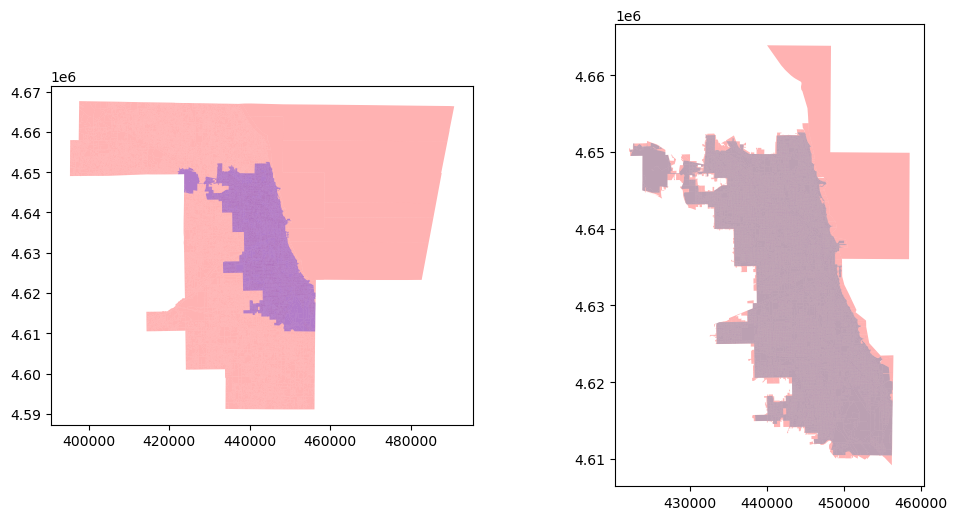

In [62]:
# visually spot check that the filtering worked as expected
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

# this should show the blue region much smaller than red
# as red is all the arcGIS blocks, blue is the filtered
blocks.plot(ax=ax1,alpha=0.3,color='red')
cityBlocks.plot(ax=ax1,alpha=0.3,color='blue')

# this should show blue smaller than red, but to a smaller extent
# The difference is that blue has boundary blocks intersected
# with the city boundary
blocks.loc[intersectCity].plot(ax=ax2,alpha=0.3,color='red')
cityBlocks.plot(ax=ax2,alpha=0.3)

C:\Users\aance\anaconda3\envs\geoEnv\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
C:\Users\aance\anaconda3\envs\geoEnv\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
C:\Users\aance\anaconda3\envs\geoEnv\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
C:\Users\aance\anaconda3\envs\geoEnv\lib\site-packages\geopandas\plotting.py:48: Shapely

Text(0.5, 1.0, 'blocks overlapping w/ the city, cut to only be within it')

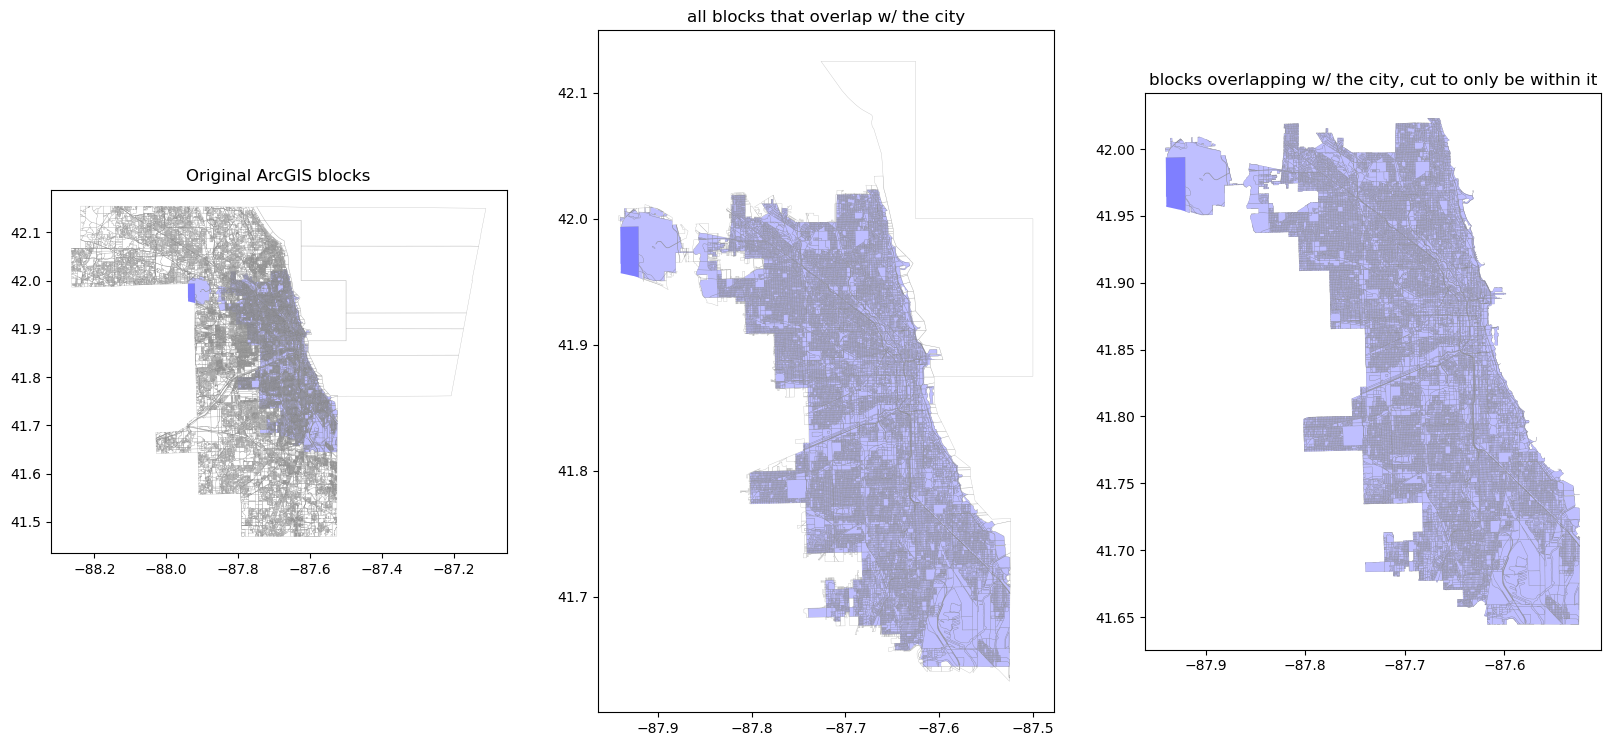

In [13]:
# here's another visual spot check/demonstration of the filtering we've done
fig,axs = plt.subplots(1,3,figsize=(20,10))
kwargs = {'color':'white','edgecolor':'grey','linewidth':0.25,'alpha':0.5}
bound.plot(ax=axs[0],color='blue',alpha=0.5)
blocks.plot(ax=axs[0],**kwargs)
axs[0].set_title('Original ArcGIS blocks')

bound.plot(ax=axs[1],color='blue',alpha=0.5)
blocks.loc[intersectCity].plot(ax=axs[1],**kwargs)
axs[1].set_title('all blocks that overlap w/ the city')

bound.plot(ax=axs[2],color='blue',alpha=0.5)
cityBlocks.plot(ax=axs[2],**kwargs)
axs[2].set_title('blocks overlapping w/ the city, cut to only be within it')

In [ ]:
# okay, so the intersection is working! But the following code block seems to indicate an issue
# it looks like some city blocks technically intersect w/ Chicago but are almost entirely
# outside the city. So when intersecting them w/ the city, we end up with just a small sliver
# This is undesirable, so perhaps lets implement a filter based on 
# area(block intersect city)/area(block) < some tolerance

C:\Users\aance\anaconda3\envs\geoEnv\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


                  TRACT BLOCK
GEOID                        
170313301011012  330101  1012


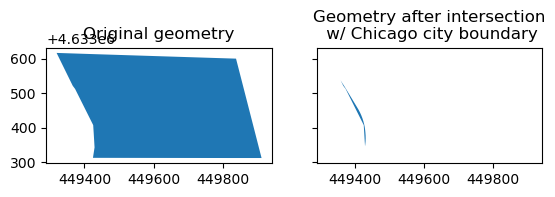

In [63]:
# example of this issue
fig,(leftAx,rightAx)= plt.subplots(1,2,sharex=True,sharey=True)
exampleBlock = cityBlocks.loc[cityBlocks['onBound']].iloc[[3]]
exampleBlock['oldGeometry'].plot(ax=leftAx) # the census block's original geometry
leftAx.set_title("Original geometry")
exampleBlock['geometry'].plot(ax=rightAx) # the census block's geometry after being intersected w/ Chicago boundary
rightAx.set_title("Geometry after intersection\n w/ Chicago city boundary")

print(exampleBlock[['TRACT','BLOCK']])

count    1.483000e+03
mean     5.427277e-01
std      4.810480e-01
min      7.252052e-09
25%      6.325428e-04
50%      9.141945e-01
75%      9.996641e-01
max      1.000000e+00
dtype: float64
39452 1483 420


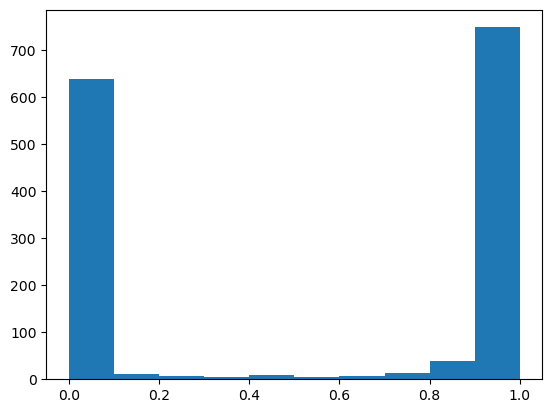

In [90]:
# how many blocks does this happen to?
# exampleBlock['geometry'].to_crs('epsg:26916').area/exampleBlock['oldGeometry'].to_crs('epsg:26916').area
r = cityBlocks.loc[cityBlocks['onBound'],'geometry'].area/cityBlocks.loc[cityBlocks['onBound'],'oldGeometry'].area
print(r.describe())
print(len(cityBlocks),len(r),(r < 0.001).sum())
h = plt.hist(r)

C:\Users\aance\anaconda3\envs\geoEnv\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
C:\Users\aance\anaconda3\envs\geoEnv\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<AxesSubplot:>

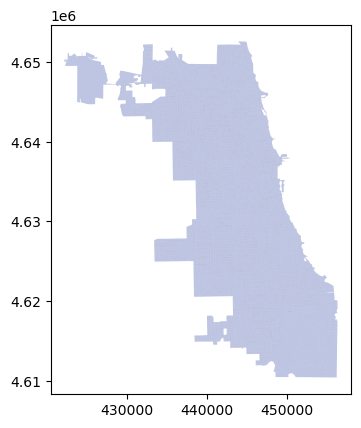

In [98]:
# apply this area filter to city blocks
ax = cityBlocks.plot(color='lightblue',alpha=0.2) # for visual spot check

tolerance = 0.001
areaRatios = cityBlocks['geometry'].area/cityBlocks['oldGeometry'].area
assert (areaRatios.loc[~cityBlocks['onBound']] >= tolerance).all() # sanity check
cityBlocks = cityBlocks.loc[areaRatios > tolerance]

cityBlocks.plot(ax=ax,color='darkblue',alpha=0.2) # for visual spot check
# we expect the lightblue and darkblue regions to be nearly indistibguishable
# because we've only filtered out really small blocks

In [ ]:
# Okay, this looks good! Done with this preprocessing step

In [99]:
# recalculate the centroids for each block (since the ones intersected w/ the boundary have now changed shapes)
cityBlocks.rename(columns={'CENTLAT':'oldCENTLAT','CENTLON':'oldCENTLON'},inplace=True)
cityBlocks['centroidLat'] = cityBlocks.centroid.y #NOTE: This is actually sort of a misnomer since cityBlocks' CRS isn't in lat/lon
cityBlocks['centroidLon'] = cityBlocks.centroid.x #NOTE: This is actually sort of a misnomer since cityBlocks' CRS isn't in lat/lon

# NOTE that the old centroid columns are in epsg:4326 but the new coords are in epsg:26916
cityBlocks[['oldCENTLAT','centroidLat','oldCENTLON','centroidLon']].head()

,oldCENTLAT,centroidLat,oldCENTLON,centroidLon
GEOID,,,,
170312001003024,+41.9325268,4.642550e+06,-087.7405959,438600.669334
170312001003016,+41.9343498,4.642752e+06,-087.7406595,438597.143406
170312001003017,+41.9361742,4.642955e+06,-087.7407233,438593.607085
170312001003002,+41.9379988,4.643158e+06,-087.7407878,438590.015092
170310510001003,+41.9428693,4.643662e+06,-087.6875213,443010.070709


39032 38946 86


C:\Users\aance\anaconda3\envs\geoEnv\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
C:\Users\aance\anaconda3\envs\geoEnv\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<AxesSubplot:>

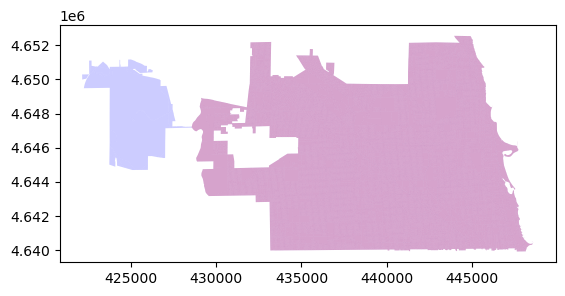

In [103]:
# next step of filtering: get rid of that blob on the top left
cutoff = 428553.2973383806 # found just on Google Maps & converting latlons to epsg:26916

print(len(cityBlocks),(cityBlocks['centroidLon'] > cutoff).sum(),(cityBlocks['centroidLon'] <= cutoff).sum())

# the latitude filter is just to zoom in on the blob-region
ax = cityBlocks.loc[cityBlocks['centroidLat'] > 4.64e6].plot(alpha=0.2,color='blue')
cityBlocks.loc[(cityBlocks['centroidLat'] > 4.64e6) & (cityBlocks['centroidLon'] > cutoff)].plot(ax=ax,color='red',alpha=0.2)

In [107]:
# okay, looks like we chose a good cutoff value. Let's apply the filter
cityBlocks = cityBlocks.loc[cityBlocks['centroidLon'] > cutoff]

C:\Users\aance\anaconda3\envs\geoEnv\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<AxesSubplot:>

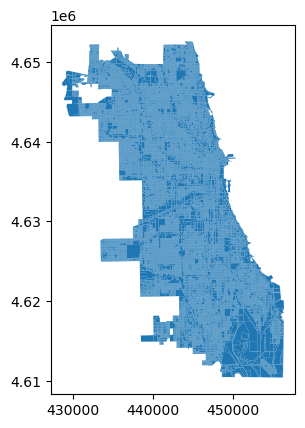

In [108]:
cityBlocks.plot()

C:\Users\aance\anaconda3\envs\geoEnv\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
C:\Users\aance\anaconda3\envs\geoEnv\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
C:\Users\aance\anaconda3\envs\geoEnv\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<AxesSubplot:>

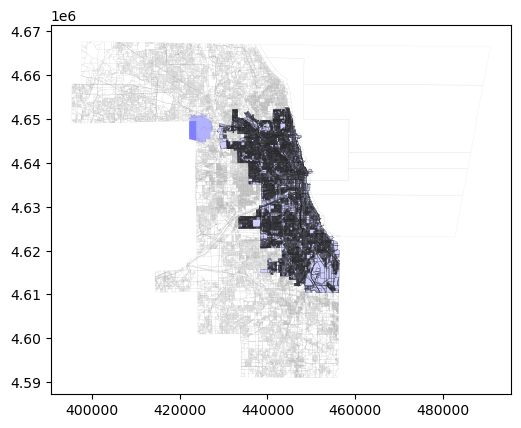

In [109]:
# Let's do one final picture summarizing the filtering work, then we'll output the result
ax = bound.plot(color='blue',alpha=0.5)
blocks.plot(ax=ax,color='white',edgecolor='gray',linewidth=0.1,alpha=0.4)
cityBlocks.plot(ax=ax,color='white',edgecolor='black',linewidth=0.25,alpha=0.4)

In [115]:
# output filtered census blocks
cityBlocks.drop(columns=['oldGeometry']).to_file('./data/processedCensusBlocks-20240209T1320.geojson',driver='GeoJSON')

In [ ]:
### Below is old work! Kept in here for posterity
# but most of the blocks prob can not/should not be run

POLYGON ((-87.609234 41.850726001000055, -87.609256 41.850958, -87.609895 41.851896, -87.609978 41.851978, -87.610072852308 41.85211963509726, -87.61001992455286 41.852056135660696, -87.61001108792705 41.85204554261901, -87.60991944396287 41.85194060112996, -87.6096789490827 41.85164797550703, -87.6094921536523 41.851420671504734, -87.60943753009765 41.851352928600114, -87.60938799693976 41.8512829940854, -87.60936125231521 41.85123960430665, -87.60934373419549 41.85121114517396, -87.6093048875442 41.85113754662214, -87.6092715621423 41.8510624737983, -87.60924383106614 41.85098611734473, -87.60922180047217 41.85090872875967, -87.60920557696605 41.850830552133864, -87.60920544192082 41.85082950846537, -87.6091965808027 41.85076575870334, -87.60918826238046 41.85068653421213, -87.60918581855755 41.85060707233353, -87.6091892476883 41.850527647208665, -87.60919854610104 41.85044845228382, -87.60920443352475 41.85041775346675, -87.60920587475935 41.85041027249219, -87.609234 41.8507260010

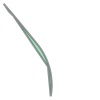

In [80]:
N = 3
print(cityBlocks.loc[cityBlocks['onBound']].head().intersection(bound.loc[0,'geometry']).iloc[N])
cityBlocks.loc[cityBlocks['onBound']].head().intersection(bound.loc[0,'geometry']).iloc[N]

MULTIPOLYGON (((-87.610548 41.85283000100003, -87.609298 41.85280600100003, -87.605549 41.852737, -87.6043 41.85271400100004, -87.604117 41.852197001000036, -87.603569 41.850648, -87.603387 41.85013200100008, -87.60456 41.850126, -87.608082 41.850111, -87.609256 41.850106, -87.609203 41.85037800100008, -87.609234 41.850726001000055, -87.609256 41.850958, -87.609895 41.851896, -87.609978 41.851978, -87.610199 41.85230800100004, -87.610548 41.85283000100003)))


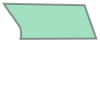

In [81]:
print(cityBlocks.loc[cityBlocks['onBound'],'geometry'].head().iloc[N])
cityBlocks.loc[cityBlocks['onBound'],'geometry'].head().iloc[N]

In [82]:
# okay... so this shows
# (1) our intersection is working! That's good
# (2) it suggests maybe we should consider some sort of area-requirement after intersecting
#     since this block probably isn't in Chicago anymore, the fact that it intersects may
#     just be an artifact of the geojson...

C:\Users\aance\anaconda3\envs\geoEnv\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
C:\Users\aance\anaconda3\envs\geoEnv\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
C:\Users\aance\anaconda3\envs\geoEnv\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
C:\Users\aance\anaconda3\envs\geoEnv\lib\site-packages\geopandas\plotting.py:48: Shapely

Text(0.5, 1.0, 'blocks overlapping w/ the city, cut to only be within it')

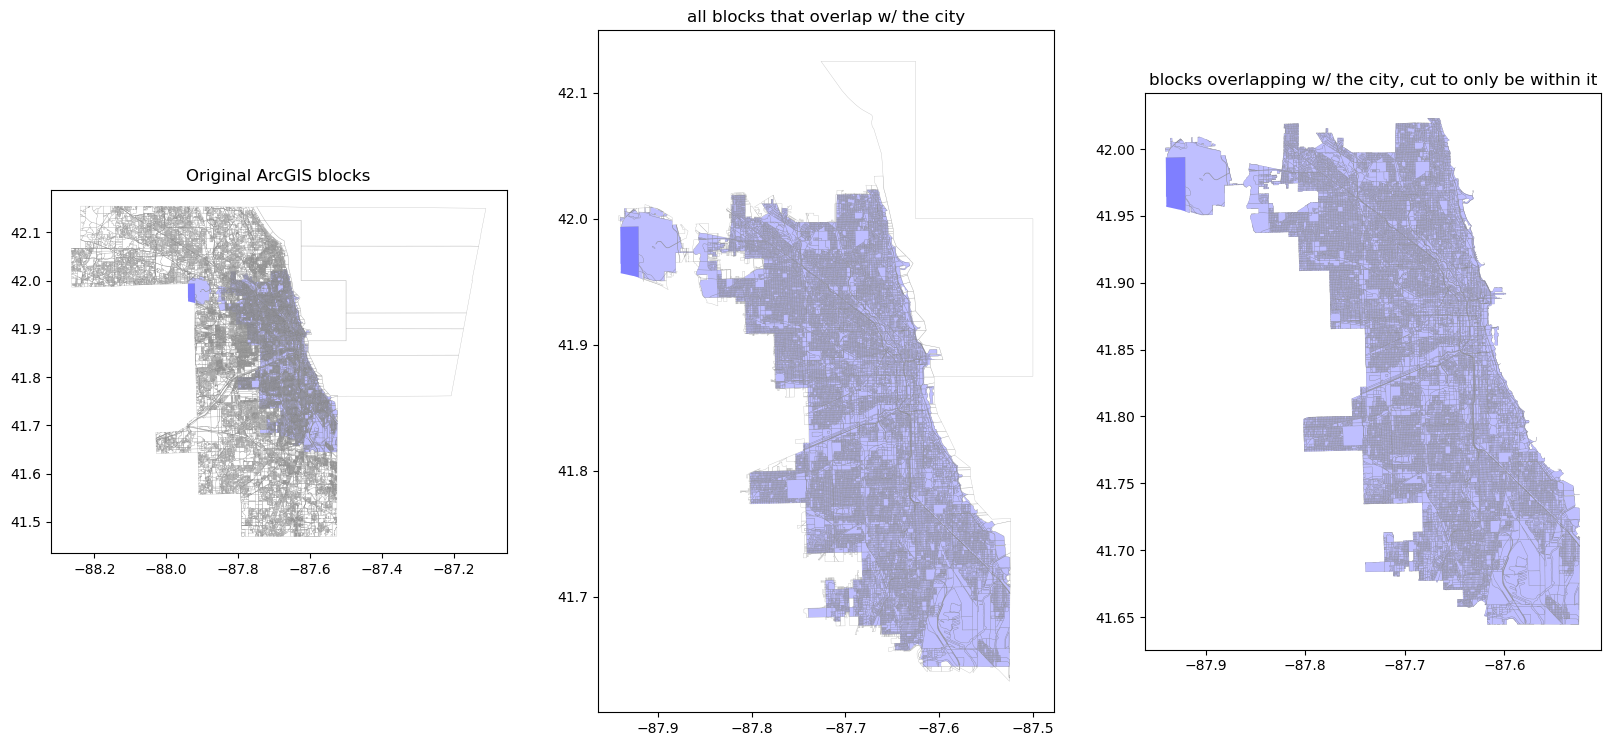

In [83]:
# plot the differences
fig,axs = plt.subplots(1,3,figsize=(20,10))
bound.plot(ax=axs[0],color='blue',alpha=0.5)
blocks.plot(ax=axs[0],color='white',edgecolor='grey',linewidth=0.25,alpha=0.5)
axs[0].set_title('Original ArcGIS blocks')

bound.plot(ax=axs[1],color='blue',alpha=0.5)
cityBlocks.plot(ax=axs[1],color='white',edgecolor='grey',linewidth=0.25,alpha=0.5)
axs[1].set_title('all blocks that overlap w/ the city')

c2 = cityBlocks.copy() # This is only bc I don't wanna permanently change cityBlocks' data just yet
c2.loc[c2['onBound'],'geometry'] = c2.loc[c2['onBound']].intersection(bound.loc[0,'geometry'])
bound.plot(ax=axs[2],color='blue',alpha=0.5)
c2.plot(ax=axs[2],color='white',edgecolor='grey',linewidth=0.25,alpha=0.5)
axs[2].set_title('blocks overlapping w/ the city, cut to only be within it')

In [48]:
# for blocks intersecting the boundary of the city but not fully within it
# intersect them w/ the city boundary
blocks.loc[onBound,'geometry'] = blocks.loc[onBound].intersection(bound.loc[0,'geometry'])
blocks['intersectBound'] = onBound # store this info in df so if write it to output, this info is stored
blocks['fullyInCity'] = inCity

In [51]:
# spot check
blocks.intersects(bound.loc[0,'geometry']).equals(blocks.within(bound.loc[0,'geometry']))

False

In [53]:
i = blocks.intersects(bound.loc[0,'geometry'])
w = blocks.within(bound.loc[0,'geometry'])
((i & ~w) | (~i & w)).sum()

1231

In [57]:
print(i.sum(),w.sum(),onBound.sum())
d = ((i & ~w) | (~i & w))
(d & onBound).equals(d)

39453 38222 1484


True

In [ ]:
# okay, so there all the weird blocks are those on the boundary
# hopefully it is just a numerical offity w/ how geopandas works

In [ ]:
# dang, that should have been True. Since any block that intersected the bound was intersected back w/ the city
# thus cutting away any extraneous region
# so presumably, every block that intersected but was not within the city is not fully within the city
# so doing 'within' and 'intersect' should now do the same thing... right?

C:\Users\aance\anaconda3\envs\geoEnv\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
C:\Users\aance\anaconda3\envs\geoEnv\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
C:\Users\aance\anaconda3\envs\geoEnv\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
C:\Users\aance\anaconda3\envs\geoEnv\lib\site-packages\geopandas\plotting.py:48: Shapely

<AxesSubplot:>

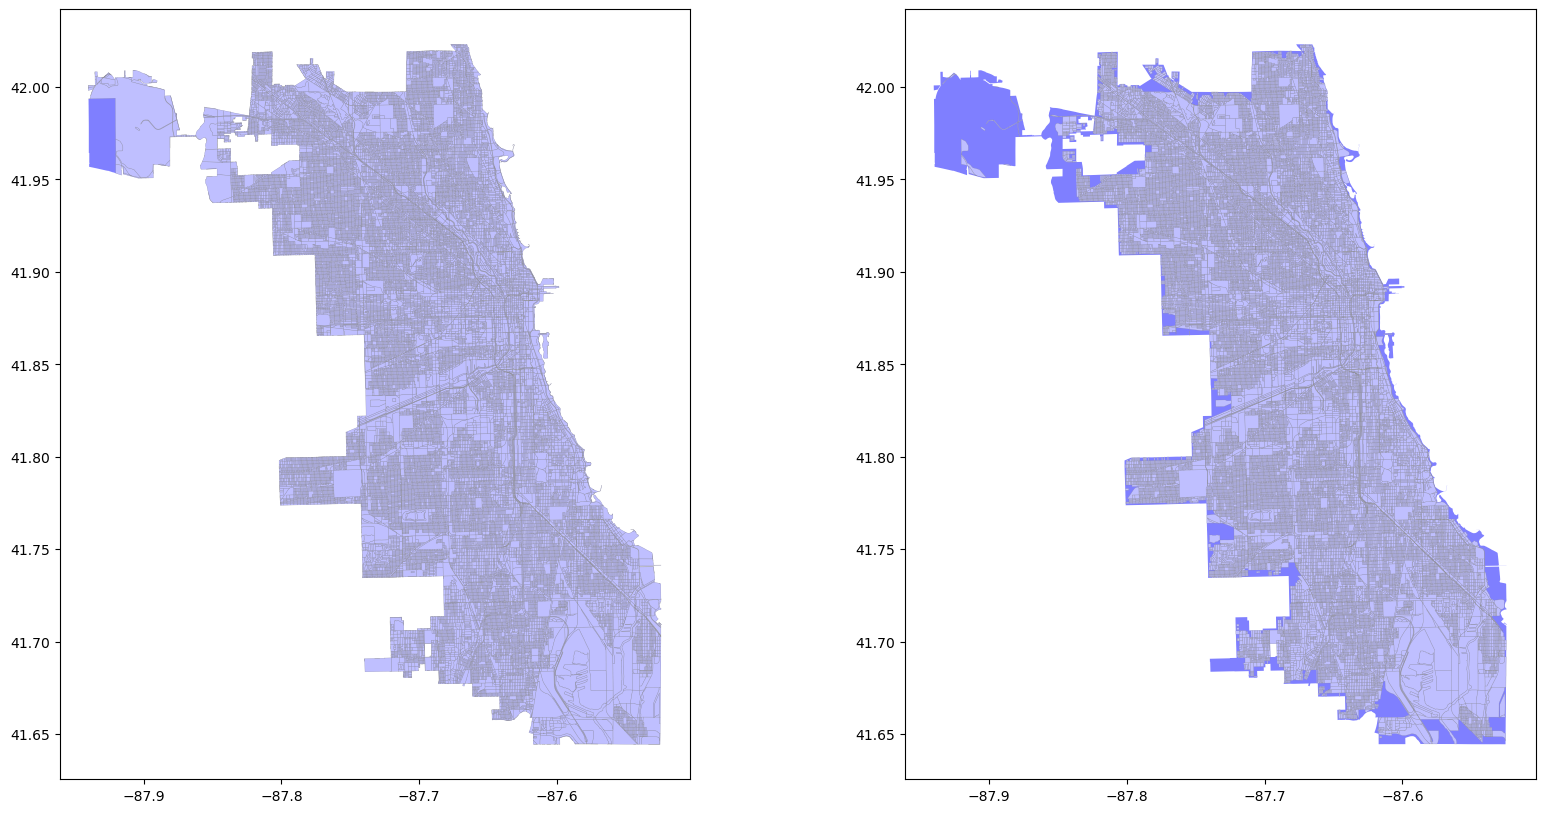

In [49]:
fig,axs = plt.subplots(1,2,figsize=(20,10))
bound.plot(ax=axs[0],color='blue',alpha=0.5)
blocks.loc[intersectCity].plot(ax=axs[0],color='white',edgecolor='grey',linewidth=0.25,alpha=0.5)

bound.plot(ax=axs[1],color='blue',alpha=0.5)
blocks.loc[inCity].plot(ax=axs[1],color='white',edgecolor='grey',linewidth=0.25,alpha=0.5)